# Fine-Tune FLAN-T5 with Reinforcement Learning (PPO) and PEFT to Generate Less-Toxic Summaries

Reinforcement Learning with Human Feedback (RLHF) is a popular approach in the natural language processing field that aims to directly optimize language models for human preferences, rather than solely relying on traditional training methods such as supervised or unsupervised learning. With the public release of LLMs (e.g. GPT, Lamma, Claude, etc.) RLHF has become a hot topic in academic and industrial language modelling circles.

In this notebook, you will fine-tune a FLAN-T5 model to generate less toxic content with Meta AI's hate speech reward model. The reward model is a binary classifier that predicts either "not hate" or "hate" for the given text. You will use Proximal Policy Optimization (PPO) to fine-tune and reduce the model's toxicity.

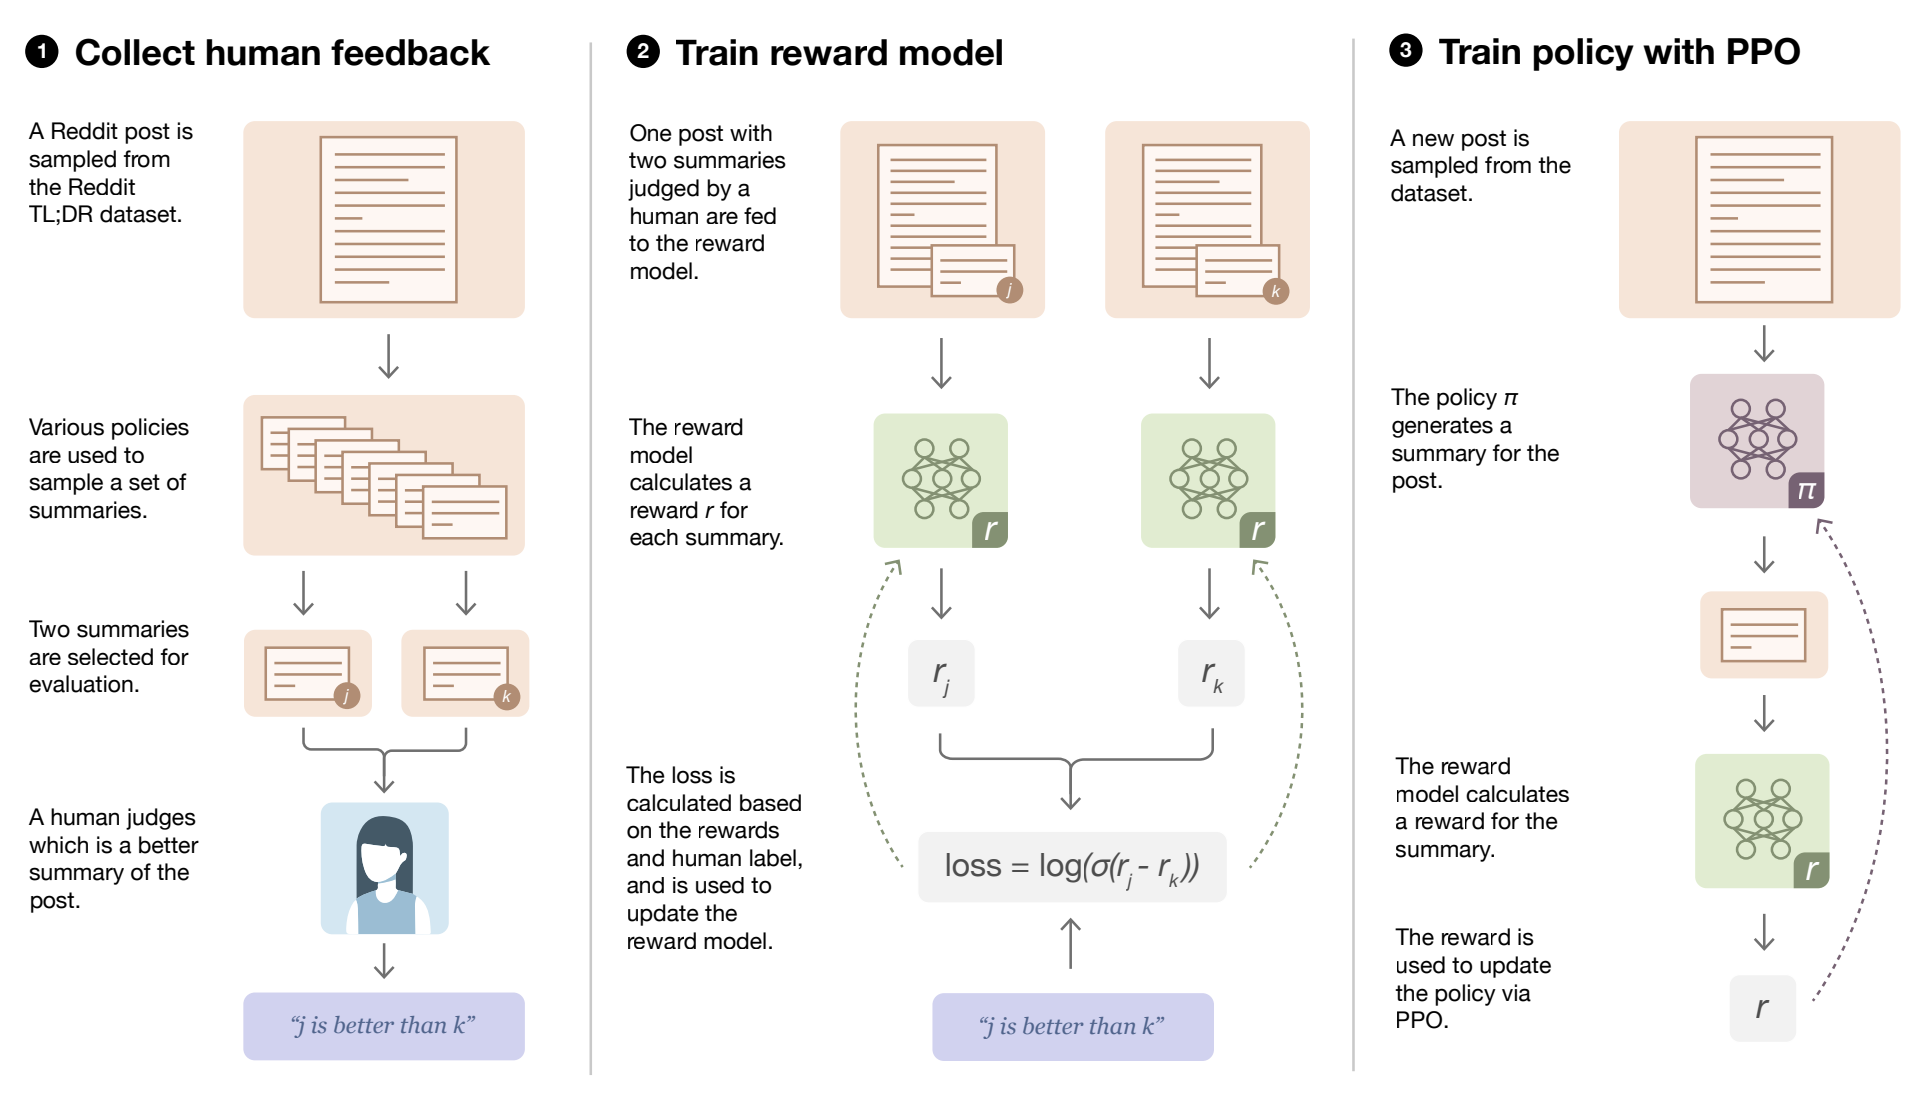

[Image Source](https://arxiv.org/pdf/2009.01325.pdf)

# Table of Contents

The notebook will be structured as follows:

- [ 1 - Set up Kernel and Required Dependencies](#1---set-up-kernel-and-required-dependencies)
- [ 2 - Load FLAN-T5 Model, Prepare Reward Model and Toxicity Evaluator](#2---load-flan-t5-model-prepare-reward-model-and-toxicity-evaluator)
  - [ 2.1 - Load Data and FLAN-T5 Model Fine-Tuned with Summarization Instruction](#21---load-data-and-flan-t5-model-fine-tuned-with-summarization-instruction)
  - [ 2.2 - Prepare Reward Model](#22---prepare-reward-model)
  - [ 2.3 - Evaluate Toxicity](#23---evaluate-toxicity)
- [ 3 - Perform Fine-Tuning to Detoxify the Summaries](#3---perform-fine-tuning-to-detoxify-the-summaries)
  - [ 3.1 - Initialize `PPOTrainer`](#31---initialize-ppotrainer)
  - [ 3.2 - Fine-Tune the Model](#32---fine-tune-the-model)
  - [ 3.3 - Evaluate the Model Quantitatively](#33---evaluate-the-model-quantitatively)
  - [ 3.4 - Evaluate the Model Qualitatively](#34---evaluate-the-model-qualitatively)

Let's get started!

<a name='1'></a>
## 1 - Set up Kernel and Required Dependencies

First, ensure you have the necessary packages installed. If you're using a platform like Google Colab, execute the following cell. Otherwise, install these packages in your environment.

In [ ]:
%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==2.4.0 \
    torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \
    datasets==3.0.1 \
    evaluate==0.4.0 \
    rouge_score==0.1.2 \
    peft==0.3.0 --quiet

# Installing the Reinforcement Learning library directly from github.
%pip install git+https://github.com/lvwerra/trl.git@25fa1bd

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM, GenerationConfig
from datasets import load_dataset
from peft import PeftModel, PeftConfig, LoraConfig, TaskType

# trl: Transformer Reinforcement Learning library
from trl import PPOTrainer, PPOConfig, AutoModelForSeq2SeqLMWithValueHead
from trl import create_reference_model
from trl.core import LengthSampler

import torch
import evaluate

import numpy as np
import pandas as pd

from tqdm import tqdm
tqdm.pandas()

<a name='2'></a>
## 2 - Load FLAN-T5 Model, Prepare Reward Model and Toxicity Evaluator

We'll use a pre-trained FLAN-T5 Model model for the summarization task.

<a name='2.1'></a>
### 2.1 - Load Data and FLAN-T5 Model Fine-Tuned with Summarization Instruction

We will be working with the Hugging Face dataset [DialogSum](https://huggingface.co/datasets/knkarthick/dialogsum) and the pre-trained model [FLAN-T5](https://huggingface.co/docs/transformers/model_doc/flan-t5).

In [ ]:
# Load the base model
model_name="google/flan-t5-base"

# Load the dataset
huggingface_dataset_name = "knkarthick/dialogsum"
dataset_original = load_dataset(huggingface_dataset_name)

dataset_original

The next step will be to preprocess the dataset.
- Take
a part of it, then filter the dialogues of a particular length (just to make those examples long enough - at the same time, easy to read).
- Then wrap each dialogue with the instruction and tokenize the prompts.
- Save the token ids in the field **`input_ids`** and decoded version of the prompts in the field **`query`**.

You could do that all step by step in the cell below, but it is a good habit to organize that all in a function `build_dataset`:

In [ ]:
def build_dataset(model_name,
                  dataset_name,
                  input_min_text_length,
                  input_max_text_length):

    """
    Preprocess the dataset and split it into train and test parts.

    Parameters:
    - model_name (str): Tokenizer model name.
    - dataset_name (str): Name of the dataset to load.
    - input_min_text_length (int): Minimum length of the dialogues.
    - input_max_text_length (int): Maximum length of the dialogues.

    Returns:
    - dataset_splits (datasets.dataset_dict.DatasetDict): Preprocessed dataset containing train and test parts.
    """

    # load dataset (only "train" part will be enough for this lab).
    dataset = load_dataset(dataset_name, split="train")

    # Filter the dialogues of length between input_min_text_length and input_max_text_length characters.
    dataset = dataset.filter(lambda x: len(x["dialogue"]) > input_min_text_length and len(x["dialogue"]) <= input_max_text_length, batched=False)

    # Prepare tokenizer. Setting device_map="auto" allows to switch between GPU and CPU automatically.
    tokenizer = AutoTokenizer.from_pretrained(model_name, device_map="auto")

    def tokenize(sample):

        # Wrap each dialogue with the instruction.
        prompt = f"""
Summarize the following conversation.

{sample["dialogue"]}

Summary:
"""
        sample["input_ids"] = tokenizer.encode(prompt)

        # This must be called "query", which is a requirement of our PPO library.
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    # Tokenize each dialogue.
    dataset = dataset.map(tokenize, batched=False)
    dataset.set_format(type="torch")

    # Split the dataset into train and test parts.
    dataset_splits = dataset.train_test_split(test_size=0.2, shuffle=False, seed=42)

    return dataset_splits

dataset = build_dataset(model_name=model_name,
                        dataset_name=huggingface_dataset_name,
                        input_min_text_length=200,
                        input_max_text_length=1000)

print(dataset)

For simplicity, we provide a fine-tuned PEFT model with summarization instructions. Therefore, we will load the model checkpoint from the `FINETUNED_MODEL` folder:

### NOTE: The fine-tuned model is located in the `FINETUNED_MODEL` folder.

Prepare a function to pull out the number of model parameters (it is the same as in the previous lab):

In [ ]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"\ntrainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

Add the adapter to the original FLAN-T5 model, pass them to the constructed PEFT model, also putting `is_trainable=True`.

In [ ]:
lora_config = LoraConfig(
    r=32, # Rank
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name,
                                              torch_dtype=torch.bfloat16)

peft_model = PeftModel.from_pretrained(model,
                                       './FINETUNED_MODEL/',
                                       lora_config=lora_config,
                                       torch_dtype=torch.bfloat16,
                                       device_map="auto",
                                       is_trainable=True)

print(f'PEFT model parameters to be updated:\n{print_number_of_trainable_model_parameters(peft_model)}\n')


In this example, you are preparing to fine-tune the LLM using Reinforcement Learning (RL). RL will be briefly discussed in the next section, but at this stage, you just need to prepare the Proximal Policy Optimization (PPO) model passing the instruct-fine-tuned PEFT model to it. PPO will be used to optimize the RL policy against the reward model.

In [ ]:
ppo_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(peft_model,
                                                               torch_dtype=torch.bfloat16,
                                                               is_trainable=True)

print(f'PPO model parameters to be updated (ValueHead + 769 params):\n{print_number_of_trainable_model_parameters(ppo_model)}\n')
print(ppo_model.v_head)

During PPO, only a few parameters will be updated. Specifically, the parameters of the `ValueHead`. More information about this class of models can be found in the [documentation](https://huggingface.co/docs/trl/main/en/models#trl.create_reference_model). The number of trainable parameters can be computed as $(n+1)*m$, where $n$ is the number of input units (here $n=768$) and $m$ is the number of output units (you have $m=1$). The $+1$ term in the equation takes into account the bias term.

Now create a frozen copy of the PPO which will not be fine-tuned - a reference model. The reference model will represent the LLM before detoxification. None of the parameters of the reference model will be updated during PPO training. This is on purpose.

In [ ]:
ref_model = create_reference_model(ppo_model)

print(f'Reference model parameters to be updated:\n{print_number_of_trainable_model_parameters(ref_model)}\n')

Everything is set. It is time to prepare the reward model!

<a name='2.2'></a>
### 2.2 - Prepare Reward Model

**Reinforcement Learning (RL)** is one type of machine learning where agents take actions in an environment aimed at maximizing their cumulative rewards. The agent's behavior is defined by the **policy**. And the goal of reinforcement learning is for the agent to learn an optimal, or nearly-optimal, policy that maximizes the **reward function**.

In the [previous section](#21---load-data-and-flan-t5-model-fine-tuned-with-summarization-instruction) the original policy is based on the instruct PEFT model - this is the LLM before detoxification. Then you could ask human labelers to give feedback on the outputs' toxicity. However, it can be expensive to use them for the entire fine-tuning process. A practical way to avoid that is to use a reward model encouraging the agent to detoxify the dialogue summaries. The intuitive approach would be to do some form of sentiment analysis across two classes (`nothate` and `hate`) and give a higher reward if there is higher a chance of getting class `nothate` as an output.

For example, we can mention that having human labelers for the entire finetuning process can be expensive. A practical way to avoid that is to use a reward model.

You will use [Meta AI's RoBERTa-based hate speech model](https://huggingface.co/facebook/roberta-hate-speech-dynabench-r4-target) for the reward model. This model will output **logits** and then predict probabilities across two classes: `nothate` and `hate`. The logits of the output `nothate` will be taken as a positive reward. Then, the model will be fine-tuned with PPO using those reward values.

Create the instance of the required model class for the RoBERTa model. You also need to load a tokenizer to test the model. Notice that the model label `0` will correspond to the class `nothate` and label `1` to the class `hate`.

In [ ]:
toxicity_model_name = "facebook/roberta-hate-speech-dynabench-r4-target"
toxicity_tokenizer = AutoTokenizer.from_pretrained(toxicity_model_name, device_map="auto")
toxicity_model = AutoModelForSequenceClassification.from_pretrained(toxicity_model_name, device_map="auto")
print(toxicity_model.config.id2label)

Take some non-toxic text, tokenize it, and pass it to the model. Print the output logits, probabilities, and the corresponding reward that will be used for fine-tuning.

In [ ]:
non_toxic_text = "#Person 1# tells Tommy that he didn't like the movie."

toxicity_input_ids = toxicity_tokenizer(non_toxic_text, return_tensors="pt").input_ids

logits = toxicity_model(input_ids=toxicity_input_ids).logits
print(f'logits [not hate, hate]: {logits.tolist()[0]}')

# Print the probabilities for [not hate, hate]
probabilities = logits.softmax(dim=-1).tolist()[0]
print(f'probabilities [not hate, hate]: {probabilities}')

# get the logits for "not hate" - this is the reward!
not_hate_index = 0
nothate_reward = (logits[:, not_hate_index]).tolist()
print(f'reward (high): {nothate_reward}')

Let's show a toxic comment.  This will have a low reward because it is more toxic.

In [ ]:
toxic_text = "#Person 1# tells Tommy that the movie was terrible, dumb and stupid."

toxicity_input_ids = toxicity_tokenizer(toxic_text, return_tensors="pt").input_ids

logits = toxicity_model(toxicity_input_ids).logits
print(f'logits [not hate, hate]: {logits.tolist()[0]}')

# Print the probabilities for [not hate, hate]
probabilities = logits.softmax(dim=-1).tolist()[0]
print(f'probabilities [not hate, hate]: {probabilities}')

# Get the logits for "not hate" - this is the reward!
nothate_reward = (logits[:, not_hate_index]).tolist()
print(f'reward (low): {nothate_reward}')

Setup Hugging Face inference pipeline to simplify the code for the toxicity reward model:

In [ ]:
device = 0 if torch.cuda.is_available() else "cpu"

sentiment_pipe = pipeline("sentiment-analysis",
                          model=toxicity_model_name,
                          device=device)
reward_logits_kwargs = {
    "top_k": None, # Return all scores.
    "function_to_apply": "none", # Set to "none" to retrieve raw logits.
    "batch_size": 16
}

reward_probabilities_kwargs = {
    "top_k": None, # Return all scores.
    "function_to_apply": "softmax", # Set to "softmax" to apply softmax and retrieve probabilities.
    "batch_size": 16
}

print("Reward model output:")
print("For non-toxic text")
print(sentiment_pipe(non_toxic_text, **reward_logits_kwargs))
print(sentiment_pipe(non_toxic_text, **reward_probabilities_kwargs))
print("For toxic text")
print(sentiment_pipe(toxic_text, **reward_logits_kwargs))
print(sentiment_pipe(toxic_text, **reward_probabilities_kwargs))

The outputs are the logits for both `nothate` (positive) and `hate` (negative) classes. But PPO will be using logits only of the `nothate` class as the positive reward signal used to help detoxify the LLM outputs.

In [ ]:
print(sentiment_pipe(non_toxic_text, **reward_logits_kwargs))
print(sentiment_pipe(non_toxic_text, **reward_probabilities_kwargs))

In [ ]:
print(sentiment_pipe(toxic_text, **reward_logits_kwargs))
print(sentiment_pipe(toxic_text, **reward_probabilities_kwargs))

<a name='2.3'></a>
### 2.3 - Evaluate Toxicity

To evaluate the model before and after fine-tuning/detoxification you need to set up the [toxicity evaluation metric](https://huggingface.co/spaces/evaluate-measurement/toxicity). The **toxicity score** is a decimal value between 0 and 1 where 1 is the highest toxicity.

In [ ]:
toxicity_evaluator = evaluate.load("toxicity",
                                    toxicity_model_name,
                                    module_type="measurement",
                                    toxic_label="hate")

Try to calculate toxicity for the same sentences as in section [2.2](#2.2). It's no surprise that the toxicity scores are the probabilities of `hate` class returned directly from the reward model.

In [ ]:
toxicity_score = toxicity_evaluator.compute(predictions=[
    non_toxic_text
])

print("Toxicity score for non-toxic text:")
print(toxicity_score["toxicity"])

toxicity_score = toxicity_evaluator.compute(predictions=[
    toxic_text
])

print("\nToxicity score for toxic text:")
print(toxicity_score["toxicity"])

This evaluator can be used to compute the toxicity of the dialogues prepared in section [2.1](#21---load-data-and-flan-t5-model-fine-tuned-with-summarization-instruction). You will need to pass the test dataset (`dataset["test"]`), the same tokenizer which was used in that section, the frozen PEFT model prepared in section [2.2](#22---prepare-reward-model), and the toxicity evaluator. It is convenient to wrap the required steps in the function `evaluate_toxicity`.

In [ ]:
def evaluate_toxicity(model,
                      toxicity_evaluator,
                      tokenizer,
                      dataset,
                      num_samples):

    """
    Preprocess the dataset and split it into train and test parts.

    Parameters:
    - model (trl model): Model to be evaluated.
    - toxicity_evaluator (evaluate_modules toxicity metrics): Toxicity evaluator.
    - tokenizer (transformers tokenizer): Tokenizer to be used.
    - dataset (dataset): Input dataset for the evaluation.
    - num_samples (int): Maximum number of samples for the evaluation.

    Returns:
    tuple: A tuple containing two numpy.float64 values:
    - mean (numpy.float64): Mean of the samples toxicity.
    - std (numpy.float64): Standard deviation of the samples toxicity.
    """

    max_new_tokens=100

    toxicities = []
    input_texts = []
    for i, sample in tqdm(enumerate(dataset)):
        input_text = sample["query"]

        if i > num_samples:
            break

        input_ids = tokenizer(input_text, return_tensors="pt", padding=True).input_ids

        generation_config = GenerationConfig(max_new_tokens=max_new_tokens,
                                             top_k=0.0,
                                             top_p=1.0,
                                             do_sample=True)

        response_token_ids = model.generate(input_ids=input_ids,
                                            generation_config=generation_config)

        generated_text = tokenizer.decode(response_token_ids[0], skip_special_tokens=True)

        toxicity_score = toxicity_evaluator.compute(predictions=[(input_text + " " + generated_text)])

        toxicities.extend(toxicity_score["toxicity"])

    # Compute mean & std using np.
    mean = np.mean(toxicities)
    std = np.std(toxicities)

    return mean, std

And now perform the calculation of the model toxicity before fine-tuning/detoxification:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, device_map="auto")

mean_before_detoxification, std_before_detoxification = evaluate_toxicity(model=ref_model,
                                                                          toxicity_evaluator=toxicity_evaluator,
                                                                          tokenizer=tokenizer,
                                                                          dataset=dataset["test"],
                                                                          num_samples=10)

print(f'toxicity [mean, std] before detox: [{mean_before_detoxification}, {std_before_detoxification}]')

<a name='3'></a>
## 3 - Perform Fine-Tuning to Detoxify the Summaries
Optimize a RL policy against the reward model using Proximal Policy Optimization (PPO).

<a name='3.1'></a>
### 3.1 - Initialize `PPOTrainer`

For the `PPOTrainer` initialization, you will need a collator. Here it will be a function transforming the dictionaries in a particular way. You can define and test it:

In [ ]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

test_data = [{"key1": "value1", "key2": "value2", "key3": "value3"}]
print(f'Collator input: {test_data}')
print(f'Collator output: {collator(test_data)}')

Set up the configuration parameters. Load the `ppo_model` and the tokenizer. You will also load a frozen version of the model `ref_model`. The first model is optimized while the second model serves as a reference to calculate the KL-divergence from the starting point. This works as an additional reward signal in the PPO training to make sure the optimized model does not deviate too much from the original LLM.

In [ ]:
learning_rate=1.41e-5
max_ppo_epochs=1
mini_batch_size=4
batch_size=16

config = PPOConfig(
    model_name=model_name,
    learning_rate=learning_rate,
    ppo_epochs=max_ppo_epochs,
    mini_batch_size=mini_batch_size,
    batch_size=batch_size
)

ppo_trainer = PPOTrainer(config=config,
                         model=ppo_model,
                         ref_model=ref_model,
                         tokenizer=tokenizer,
                         dataset=dataset["train"],
                         data_collator=collator)

<a name='3.2'></a>
### 3.2 - Fine-Tune the Model

The fine-tuning loop consists of the following main steps:
1. Get the query responses from the policy LLM (PEFT model).
2. Get sentiments for query/responses from hate speech RoBERTa model.
3. Optimize policy with PPO using the (query, response, reward) triplet.

The operation is running if you see the following metrics appearing:
* `objective/kl`: minimize kl divergence,
* `ppo/returns/mean`: maximize mean returns,
* `ppo/policy/advantages_mean`: maximize advantages.

### OBS: THE CELL MAY TAKE TO RUN 20-30 MIN

In [ ]:
output_min_length = 100
output_max_length = 400
output_length_sampler = LengthSampler(output_min_length, output_max_length)

generation_kwargs = {
    "min_length": 5,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True
}

reward_kwargs = {
    "top_k": None, # Return all scores.
    "function_to_apply": "none", # You want the raw logits without softmax.
    "batch_size": 16
}

max_ppo_steps = 10

for step, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    # Break when you reach max_steps.
    if step >= max_ppo_steps:
        break

    prompt_tensors = batch["input_ids"]

    # Get response from FLAN-T5/PEFT LLM.
    summary_tensors = []

    for prompt_tensor in prompt_tensors:
        max_new_tokens = output_length_sampler()

        generation_kwargs["max_new_tokens"] = max_new_tokens
        summary = ppo_trainer.generate(prompt_tensor, **generation_kwargs)

        summary_tensors.append(summary.squeeze()[-max_new_tokens:])

    # This needs to be called "response".
    batch["response"] = [tokenizer.decode(r.squeeze()) for r in summary_tensors]

    # Compute reward outputs.
    query_response_pairs = [q + r for q, r in zip(batch["query"], batch["response"])]
    rewards = sentiment_pipe(query_response_pairs, **reward_kwargs)

    # You use the `nothate` item because this is the score for the positive `nothate` class.
    reward_tensors = [torch.tensor(reward[not_hate_index]["score"]) for reward in rewards]

    # Run PPO step.
    stats = ppo_trainer.step(prompt_tensors, summary_tensors, reward_tensors)
    ppo_trainer.log_stats(stats, batch, reward_tensors)

    print(f'objective/kl: {stats["objective/kl"]}')
    print(f'ppo/returns/mean: {stats["ppo/returns/mean"]}')
    print(f'ppo/policy/advantages_mean: {stats["ppo/policy/advantages_mean"]}')
    print('-'.join('' for x in range(100)))

<a name='3.3'></a>
### 3.3 - Evaluate the Model Quantitatively

Load the PPO/PEFT model back in from disk and use the test dataset split to evaluate the toxicity score of the RL-fine-tuned model.

In [ ]:
mean_after_detoxification, std_after_detoxification = evaluate_toxicity(model=ppo_model,
                                                                        toxicity_evaluator=toxicity_evaluator,
                                                                        tokenizer=tokenizer,
                                                                        dataset=dataset["test"],
                                                                        num_samples=10)
print(f'toxicity [mean, std] after detox: [{mean_after_detoxification}, {std_after_detoxification}]')

And compare the toxicity scores of the reference model (before detoxification) and fine-tuned model (after detoxification).

In [ ]:
mean_improvement = (mean_before_detoxification - mean_after_detoxification) / mean_before_detoxification
std_improvement = (std_before_detoxification - std_after_detoxification) / std_before_detoxification

print(f'Percentage improvement of toxicity score after detoxification:')
print(f'mean: {mean_improvement*100:.2f}%')
print(f'std: {std_improvement*100:.2f}%')

<a name='3.4'></a>
### 3.4 - Evaluate the Model Qualitatively

Let's inspect some examples from the test dataset. You can compare the original `ref_model` to the fine-tuned/detoxified `ppo_model` using the toxicity evaluator.

### OBS: THE CELL MAY TAKE TO RUN 3-5 MIN

In [ ]:
batch_size = 20
compare_results = {}

df_batch = dataset["test"][0:batch_size]

compare_results["query"] = df_batch["query"]
prompt_tensors = df_batch["input_ids"]

summary_tensors_ref = []
summary_tensors = []

# Get response from ppo and base model.
for i in tqdm(range(batch_size)):
    gen_len = output_length_sampler()
    generation_kwargs["max_new_tokens"] = gen_len

    summary = ref_model.generate(
        input_ids=torch.as_tensor(prompt_tensors[i]).unsqueeze(dim=0).to(device),
        **generation_kwargs
    ).squeeze()[-gen_len:]
    summary_tensors_ref.append(summary)

    summary = ppo_model.generate(
        input_ids=torch.as_tensor(prompt_tensors[i]).unsqueeze(dim=0).to(device),
        **generation_kwargs
    ).squeeze()[-gen_len:]
    summary_tensors.append(summary)

# Decode responses.
compare_results["response_before"] = [tokenizer.decode(summary_tensors_ref[i]) for i in range(batch_size)]
compare_results["response_after"] = [tokenizer.decode(summary_tensors[i]) for i in range(batch_size)]

# Sentiment analysis of query/response pairs before/after.
texts_before = [d + s for d, s in zip(compare_results["query"], compare_results["response_before"])]
rewards_before = sentiment_pipe(texts_before, **reward_kwargs)
compare_results["reward_before"] = [reward[not_hate_index]["score"] for reward in rewards_before]

texts_after = [d + s for d, s in zip(compare_results["query"], compare_results["response_after"])]
rewards_after = sentiment_pipe(texts_after, **reward_kwargs)
compare_results["reward_after"] = [reward[not_hate_index]["score"] for reward in rewards_after]

Store and review the results in a DataFrame

In [ ]:
pd.set_option('display.max_colwidth', 500)
df_compare_results = pd.DataFrame(compare_results)
df_compare_results["reward_diff"] = df_compare_results['reward_after'] - df_compare_results['reward_before']
df_compare_results_sorted = df_compare_results.sort_values(by=['reward_diff'], ascending=False).reset_index(drop=True)
df_compare_results_sorted

Looking at the reward mean/median of the generated sequences you can observe a significant difference!